In [7]:
import yfinance as yf
import gudhi as gd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gudhi.representations
from datetime import timedelta
from pandas.tseries.offsets import BDay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.signal import periodogram

stock_names = ['AAPL','TSLA','AMZN']

start_date = datetime.date(2020, 1, 1)
end_date = datetime.date(2022, 12, 31)

# stock_data = {stock: yf.download(stock, start=start_date, end=end_date) 
#               for stock in stock_names}

stock_data = yf.download(['AAPL','TSLA','AMZN'], 
                         start=start_date, end=end_date)['Close'] 

[*********************100%***********************]  3 of 3 completed


In [9]:
def scaling(dataset, scaler = StandardScaler()):

    """
    Compute the log return and then scale it.

    INPUT:
    dataset: (pd.DataFrame) Dataframe of Close prices, index is a DateTime object
    scaler: Scaler with which we want to scale the log retun (default: StandardScaler())

    OUTPUT:
    log_return: (pd.DataFrame) Dataframe of scaled log return
    """

    ratio = np.log(dataset.pct_change().dropna() +1)
    log_return = pd.DataFrame(scaler.fit_transform(ratio),columns = dataset.columns)
    log_return.set_index(dataset.iloc[1:].index, inplace = True)
    return log_return

def persistenceDgr(dataset, t, w):

    """
    Plot the persistence diagram associated to the dataset, at time t, with  points corresponding to the w Buisness Days preceeding the date t (t is not included)

    INPUT:
    dataset: (pd.DataFrame) Dataframe of daily log-returns, time-indexed
    t: (datetime) date for which we plot the persistence diagram (not included in the cloud of points)
    w: (int) window on wich we compute the persistence diagram, i.e. size of the cloud of points

    OUTPUT:
    plot of the persistence diagram
    
    """

    points = dataset[t-BDay(w): t].to_numpy()
    skeleton = gd.RipsComplex(points = points)
    Rips_tree = skeleton.create_simplex_tree(max_dimension = 2)
    dgr = Rips_tree.persistence()
    gd.plot_persistence_diagram(dgr)
    plt.show()

def persistenceLandscape(dataset, t, w):

    """
    Compute the persistence landscape associated to the dataset, at time t, with  points corresponding to the w Buisness Days preceeding the date t (t is not included)

    INPUT:
    dataset: (pd.DataFrame) Dataframe of daily log-returns, time-indexed
    t: (datetime) date for which we plot the persistence landscape (not included in the cloud of points)
    w: (int) window on wich we compute the persistence landscape, i.e. size of the cloud of points

    OUTPUT:
    L[0]: (numpy.ndarray) persistence landscape
    
    """


    points = dataset[t-BDay(w): t].to_numpy()
    skeleton = gd.RipsComplex(points = points)
    Rips_tree = skeleton.create_simplex_tree(max_dimension = 2)
    dgr = Rips_tree.persistence()
    LS = gd.representations.Landscape(resolution=1000)
    L = LS.fit_transform([Rips_tree.persistence_intervals_in_dimension(1)])
    return L[0]

def computePersistenceSeq(dataset, w, p_norms):

    """
    Compute the Lp norms of the persistence landscapes associated to the dataset

    INPUT:
    dataset: (pd.DataFrame) Dataframe of daily log-returns, time-indexed
    w: (int) window on wich we compute the persistence diagram, i.e. size of the clouds of points
    p_norms: (list of int) list of p for which we want to compute the Lp_norm

    OUTPUT:
    result: (pd.DataFrame) Dataframe of Lp_norms of persistence landscapes, time_indexed

    """

    diagrams = {}
    for t in dataset.index[w+1:]:
        points = dataset[t-BDay(w): t].to_numpy()
        skeleton = gd.RipsComplex(points = points)
        Rips_tree = skeleton.create_simplex_tree(max_dimension = 2)
        dgr = Rips_tree.persistence()

        LS = gd.representations.Landscape()
        L = LS.fit_transform([Rips_tree.persistence_intervals_in_dimension(1)])
        
        norms = [np.linalg.norm(L[0], ord = p) for p in p_norms]
        diagrams[t] = norms
    
    result = pd.DataFrame(diagrams).transpose()
    result.columns = [f'L{p}_norm' for p in p_norms]
    return result



def normalization_Lp(norms, scaler = StandardScaler()):

    """
    Normalize the Lp norms previously computed with scaler of choice

    INPUT:
    norms: (pd.DataFrame) of Lp norms, DateTime index
    scaler: scaler of choice (default: StandardScaler())

    OUTPUT:
    norms_normalized: (pd.DataFrame) of normalized norms, same index as norms
    """

    norms_normalized = pd.DataFrame(scaler.fit_transform(norms),columns = norms.columns)
    norms_normalized.set_index(norms.index, inplace = True)
    return norms_normalized



def avgPSD_total(Serie ,freq_cut):

    """
    Compute the average of the power spectral density, with frequence less than freq_cut

    INPUT:
    Serie: (pd.Serie) of normalized Lp norm for which we will compute the average PSD
    freq_cut: (float) we compute the average for the powers associated to freq lower than freq_cut

    OUTPUT:
    (int) average PSD over the whole pd.Series
    
    """

    (f,S)= periodogram(Serie,scaling = 'density')
    df_freq = pd.DataFrame((f,S), index = ['frequency','PSD']).transpose()
    return df_freq[df_freq['frequency'] < freq_cut]['PSD'].mean()


def avgPSD(data, freq_cut, w):

    """
    Compute the average PSD for each time with a preceding window of size w, for freq lower than freq_cut

    INPUT:
    data : (pd.Dataframe) of normalized Lp norm for which we compute the rolling average PSD
    freq_cut: (float) frequence maximum threshold
    w: (int) size of the rolling window

    OUTPUT:
    (pd.Dataframe) time-indexed of average PSD for each rolling window and each Lp norm column in data
    """

    return data.rolling(w).agg(lambda x : avgPSD_total(x, freq_cut)).dropna()


def rolling_std(data, w):

    """
    Compute the rolling variance for each time with a preceding window of size w

    INPUT:
    data : (pd.Dataframe) of normalized Lp norm for which we compute the rolling variance
    w: (int) size of the rolling window

    OUTPUT:
    (pd.Dataframe) time-indexed of rolling variance and each Lp norm column in data
    """

    return data.rolling(w).var().dropna()

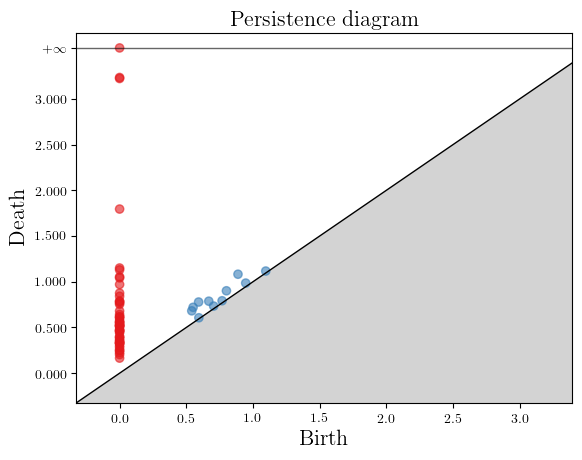

In [14]:
scaled_data = scaling(stock_data)
persistenceDgr(scaled_data, datetime.date(2022, 11, 25),50)

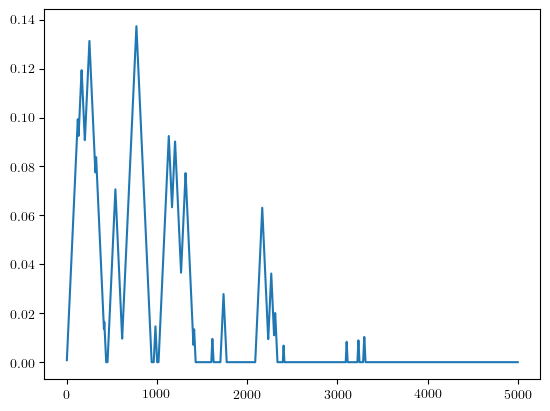

In [15]:
plt.plot(persistenceLandscape(scaled_data, datetime.date(2022, 11, 25),50))
plt.show()

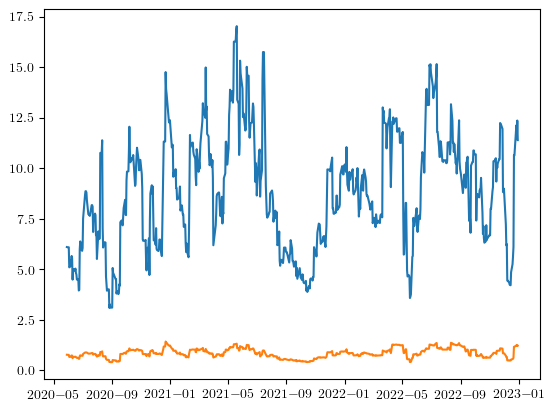

In [16]:
Lp_norms = computePersistenceSeq(data_scaled, 100,[1,2])
Lp_norms_normalized = normalization_Lp(Lp_norms)
plt.plot(Lp_norms)
plt.show()

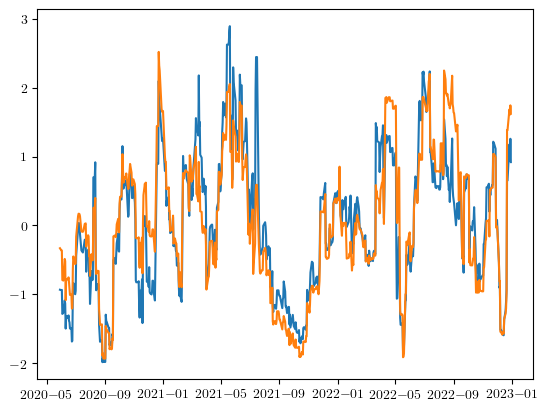

In [17]:
plt.plot(Lp_norms_normalized)
plt.show()